In [44]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
uncalibrated_base_dir = Path("..")/"../uncalibrated_data/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
minstop_table_dir = Path("..")/"../minstop_calibrate_full_tables/"
largeprior_table_dir = Path("..")/"../xtreme_prior_full_tables/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

In [53]:
legend_order = ['bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian | a=100 | b=100 ',
                'bayesian | a=500 | b=500 ',
                'bayesian | a=1000 | b=1000 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        assert False
            
def filter_legend(row):
    name = row.name
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return True
    else:
        return False

def reorder_df(df):
    m = df.apply(filter_legend, axis=1)
    df = df[m]
    return df.loc[sorted(df.index, key=get_position)]

def read_csv(df, reorder=True):
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [54]:
cols = sns.color_palette("bright", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [55]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        ls.append(ls_dict[legend])
        cs.append(cs_dict[legend])
        ms.append(ms_dict[legend])
    return cs, ls, ms

In [56]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [57]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p', value_name='expected_sample')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    return data_long

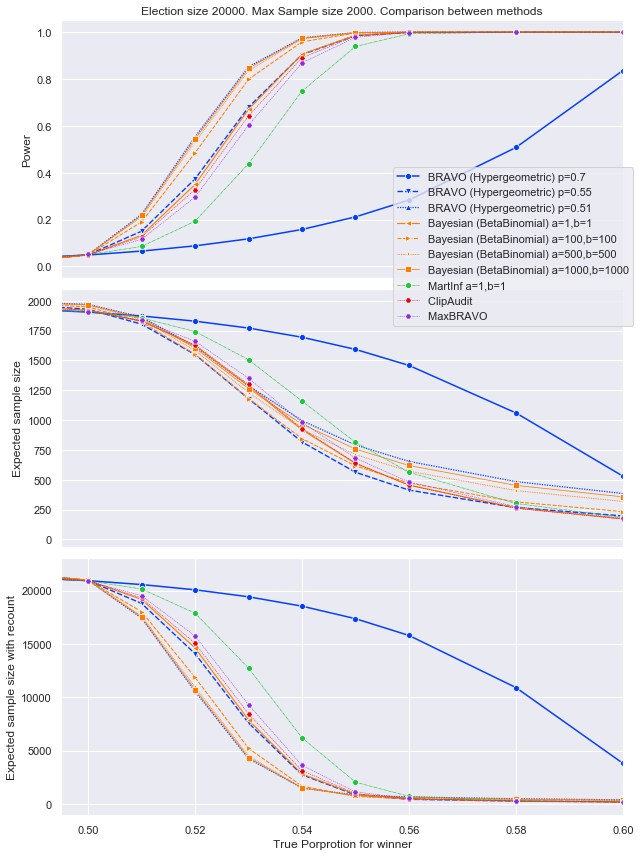

In [58]:
# 1. Basic 20000/2000 plot without replacement

# data
election = Election(20000, 2000, 0.5, 1, False)

fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_path2 = largeprior_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(
    pd.concat([pd.read_csv(data_path), pd.read_csv(data_path2)])
))

ax = fig.add_subplot(311)
ax.set_title("Election size 20000. Max Sample size 2000. Comparison between methods")
_ax = ax

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_xlim([0.495, 0.6])
ax.set_ylabel("Power")

data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_path2 = largeprior_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(
    pd.concat([pd.read_csv(data_path), pd.read_csv(data_path2)])
))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_path2 = largeprior_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(
    pd.concat([pd.read_csv(data_path), pd.read_csv(data_path2)])
))

ax.xaxis.set_visible(False)
ax.set_xlim([0.495, 0.6])
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
ax.set_xlim([0.495, 0.6])
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
make_legend(data_long, _ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/combine_mean_sample_20000.png')

# Compare with/without minstopping

### No min stop

In [ ]:
pdf_path = ('/Users/Dovermore/Documents/Research/AustralianElectionAuditing/AuditAnalysis.nosync/' + 
              'new_calibrate_full/n=001000_m=01000=0.500_replacement=False_step=1/bravo_without_replacement_0.05/bravo_without_replacement_pdf.csv')
cdf_path = ('/Users/Dovermore/Documents/Research/AustralianElectionAuditing/AuditAnalysis.nosync/' + 
              'new_calibrate_full/n=001000=01000=0.500_replacement=False_step=1/bravo_without_replacement_0.05/bravo_without_replacement_cdf.csv')